In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
from datasets import load_from_disk
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score

In [2]:
def pca_svc(C, x, y):
    """
    Extract the top 5 principal components and use a SVM to predict categorical
    label, 3 fold CV.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        x, y, stratify=y, random_state=42
    )
    pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('pca', PCA(n_components=5)), 
        ('svc', SVC(C=C, class_weight='balanced'))
    ])
    cv = StratifiedKFold(n_splits=3)
    scores = cross_val_score(pipe, X_train, y_train, cv=cv)
    y_pred = cross_val_predict(pipe, X_train, y_train, cv=cv)

    overall_acc = accuracy_score(y_pred=y_pred, y_true=y_train)
    overall_cr = classification_report(y_pred=y_pred, y_true=y_train)
    overall_cm = confusion_matrix(y_pred=y_pred, y_true=y_train)
    print('Overall Accuracy:', overall_acc)
    print(overall_cr)

    thresh = overall_cm.max() / 2
    cmdf = pd.DataFrame(overall_cm, index = ['Adult','Child'], columns = ['Adult','Child'])
    sns.heatmap(cmdf, cmap='copper', annot=cmdf)
    plt.xlabel('Predicted')
    plt.ylabel('Observed')
    

## Prediction on adult vs child with giga connectome data processing workflow

Since the atlas covers cerebellum, this should overfit very easily

Overall Accuracy: 0.9224137931034483
              precision    recall  f1-score   support

       adult       0.86      0.76      0.81        25
       child       0.94      0.97      0.95        91

    accuracy                           0.92       116
   macro avg       0.90      0.86      0.88       116
weighted avg       0.92      0.92      0.92       116

Overall Accuracy: 0.5086206896551724
              precision    recall  f1-score   support

       adult       0.17      0.32      0.22        25
       child       0.75      0.56      0.64        91

    accuracy                           0.51       116
   macro avg       0.46      0.44      0.43       116
weighted avg       0.62      0.51      0.55       116



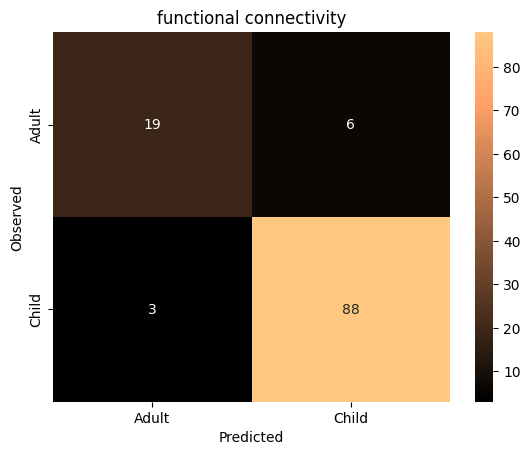

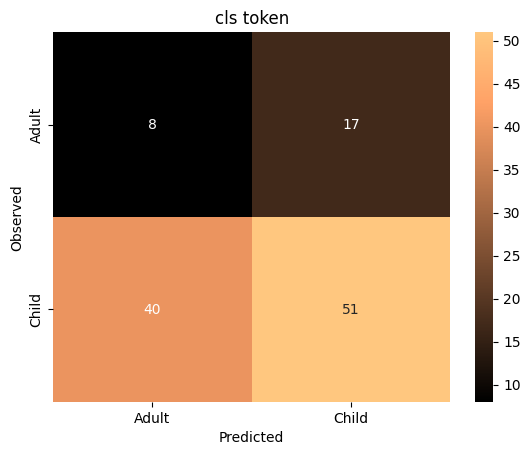

In [3]:
features = load_from_disk("../outputs/development_fmri_gigaconnectome_a424_111M.arrow")
# features = load_from_disk("../outputs/development_fmri_brainlm_a424_111M.arrow")
y_ageclass = np.array(features['Child_Adult'])
cls_token = np.array(features['cls_token']).squeeze()
correlation_measure = ConnectivityMeasure(
    kind="correlation", vectorize=True, discard_diagonal=True
)
ts = [np.array(example).reshape(3, 424, 160)[0].T for example in features['padded_recording']]
fc = correlation_measure.fit_transform(ts)
plt.figure()
plt.title("functional connectivity")
pca_svc(1000, fc, y_ageclass)
plt.figure()
plt.title("cls token")
pca_svc(1, cls_token, y_ageclass)

## Prediction on adult vs child with brainlm data processing workflow

Since the atlas covers cerebellum, this should overfit very easilyon child vs adult

Overall Accuracy: 0.9137931034482759
              precision    recall  f1-score   support

       adult       0.80      0.80      0.80        25
       child       0.95      0.95      0.95        91

    accuracy                           0.91       116
   macro avg       0.87      0.87      0.87       116
weighted avg       0.91      0.91      0.91       116

Overall Accuracy: 0.6896551724137931
              precision    recall  f1-score   support

       adult       0.21      0.16      0.18        25
       child       0.78      0.84      0.81        91

    accuracy                           0.69       116
   macro avg       0.50      0.50      0.50       116
weighted avg       0.66      0.69      0.67       116



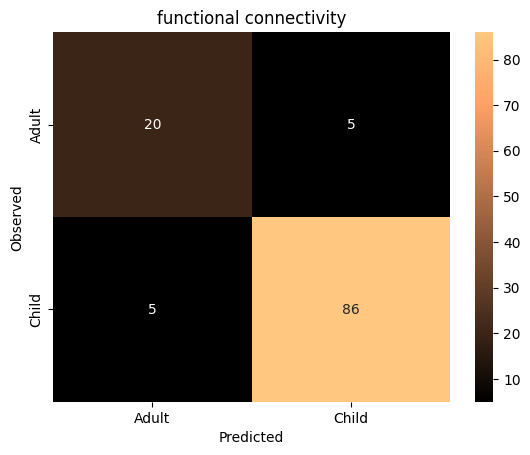

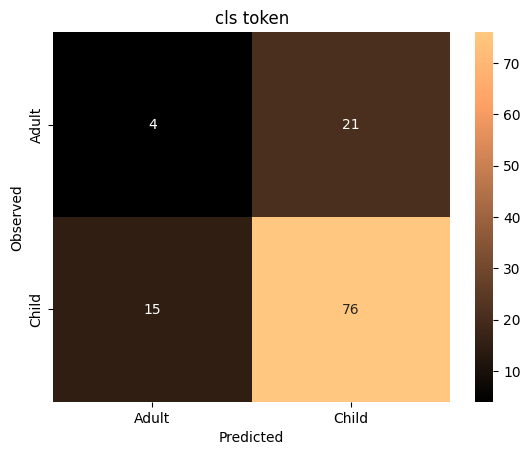

In [4]:
features = load_from_disk("../outputs/development_fmri_brainlm_a424_111M.arrow")
y_ageclass = np.array(features['Child_Adult'])
cls_token = np.array(features['cls_token']).squeeze()
correlation_measure = ConnectivityMeasure(
    kind="correlation", vectorize=True, discard_diagonal=True
)
ts = [np.array(example).reshape(3, 424, 160)[0].T for example in features['padded_recording']]
fc = correlation_measure.fit_transform(ts)

plt.figure()
plt.title("functional connectivity")
pca_svc(1000, fc, y_ageclass)
plt.figure()
plt.title("cls token")
pca_svc(1, cls_token, y_ageclass)